# Introduction

Our neural network should map the function $\rho(x)$ following the logic
$$ S(p^2) = \int_{-\infty}^\infty dk\ \theta(|k|-M_t) K(p^2, k) \rho(k) $$
where $K$ takes many forms. 

# Imports and Set Up

In [1]:
import torch
import torch.nn as nn
import pandas as pd 
import matplotlib.pyplot as plt

from torch.nn import MSELoss, L1Loss
from torchquad import Simpson, set_up_backend
from torch.utils.data import Dataset, DataLoader

from src.dataset import CustomPandasDataset
from src.models.model import FunctionNet
from src.models.controller import NeuralNetController
from src.utils import plot_model, plot_loss

INPUT_SIZE = 1
OUTPUT_SIZE = 1
EPOCHS = 20
M_thr = 1.147
MODEL_NAME = "1st_test_model"
best_vloss = 1_000_000.

df = pd.read_csv("PROP.DAT", sep="\s+")


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
set_up_backend("torch", data_type="float32")
generator = torch.Generator(device=device)

model = FunctionNet(hidden_size=60).to(device)
model_controller = NeuralNetController(
    model=model, model_path=f"src/models/models/{MODEL_NAME}.pt"
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



/home/lucas/PythonProjects/MLForIllPosedness/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
23:20:28|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
/home/lucas/PythonProjects/MLForIllPosedness/venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def load_dataset(name: str, df: pd.DataFrame, batch_size: int = None, generator = None) -> DataLoader:
    kernel_data = CustomPandasDataset(
        name=name, df=df
    )
    kernel_loader = DataLoader(kernel_data, batch_size=batch_size, shuffle=True, generator=generator)

    return kernel_loader


data_names = ["S_S", "Sprime_S", "S_V", "Sprime_V"]
data_loaders = {
    name: load_dataset(name, df, generator=generator, batch_size=32) for name in data_names
}


In [3]:
from src.settings import kernels
from src.decorators import register

@register
def S_S(x2, k):
    return k / (torch.pow(k, 2) + x2)

@register
def Sprime_S(x2, k):
    return k / torch.pow((torch.pow(k, 2) + x2), 2)

@register
def S_V(x2, k):
    return 1 / (torch.pow(k, 2) + x2)

@register
def Sprime_V(x2, k):
    return 1 / torch.pow((torch.pow(k, 2) + x2), 2)

kernels


{'kernel_1': <function src.kernels.kernel_1(x, k)>,
 'kernel_2': <function src.kernels.kernel_2(x, k)>,
 'kernel_3': <function src.kernels.kernel_3(x, k)>,
 'kernel_4': <function src.kernels.kernel_4(x, k)>,
 'kernel_5': <function src.kernels.kernel_5(x, k)>,
 'S_S': <function __main__.S_S(x2, k)>,
 'Sprime_S': <function __main__.Sprime_S(x2, k)>,
 'S_V': <function __main__.S_V(x2, k)>,
 'Sprime_V': <function __main__.Sprime_V(x2, k)>}

# Train

In [4]:
def train_one_epoch(
    epoch_index,  
    optimizer: torch.optim = None,
    data_loader: torch.utils.data.DataLoader = None,
    model: torch.nn = None,
    kernel=None
):
    loss_data = []
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(data_loader):
        inputs, labels = data

        optimizer.zero_grad()

        output = model.evaluate(inputs, kernel=kernel, M=M_thr)

        loss = L1Loss()
        mse_error = loss(output, labels)
        print(f"\tLoss ({i}) - {mse_error}")
        mse_error.backward()

        optimizer.step()

        # Gather data and report
        running_loss += mse_error.item()
        loss_data.append(mse_error.item())
        if i % 10 == 0:
            plot_model(i, model=model, kernel=kernel, epoch=epoch_index)
            last_loss = running_loss / 100 # loss per batch
            running_loss = 0.

    plot_model(i, model=model, kernel=kernel, epoch=epoch_index)
    plot_loss(i, loss_data, epoch=epoch_index)

    plt.show()
    
    return last_loss


/home/lucas/PythonProjects/MLForIllPosedness/venv/lib/python3.11/site-packages/torchquad/integration/simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 100000 -> 99999.
  warnings.warn(
/home/lucas/PythonProjects/MLForIllPosedness/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


-------------- EPOCH 1 --------------
Running kernel S_S
	Loss (0) - 0.0004447720366304108
	Loss (1) - 0.06790263864324021
	Loss (2) - 0.016896658762290795
	Loss (3) - 0.0029845592394643567
	Loss (4) - 0.024004534630195404
	Loss (5) - 0.0973593402362882
	Loss (6) - 0.003242906984131818
	Loss (7) - 0.00048816096263756066
	Loss (8) - 0.0019106679803304587
	Loss (9) - 0.006426640867328999
	Loss (10) - 0.007967999786705008
	Loss (11) - 0.004894914859451552
	Loss (12) - 0.0031575887089423204
	Loss (13) - 0.003835410541807597
	Loss (14) - 0.01229171821056581
	Loss (15) - 0.01037502837312008


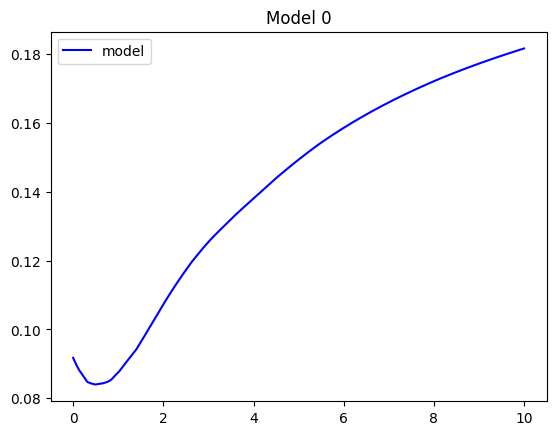

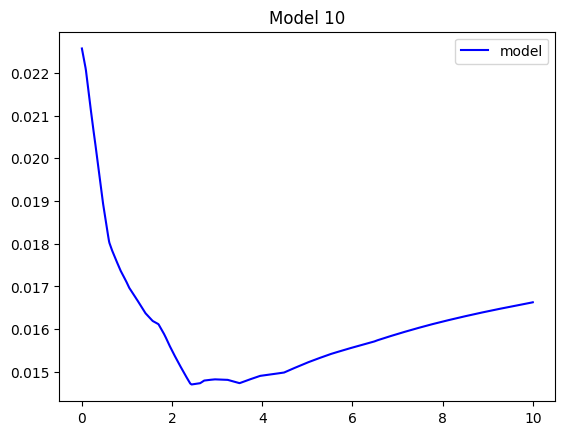

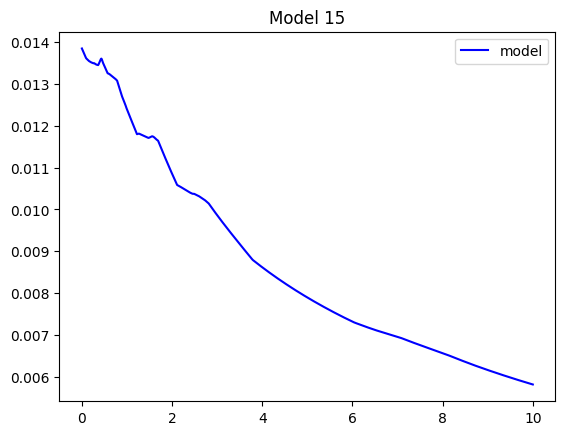

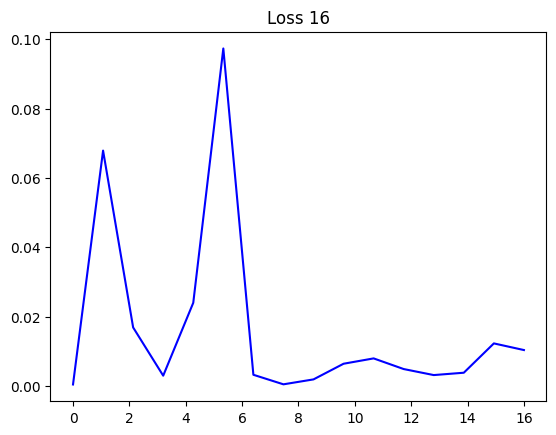

LOSS train 0.0022918410809261284
-------------- EPOCH 2 --------------
Running kernel Sprime_S
	Loss (0) - 1.571694375460237e-05
	Loss (1) - 4.1997120369226005e-05
	Loss (2) - 1.646042931596718e-05
	Loss (3) - 1.1544033567978192e-05
	Loss (4) - 8.535124429153737e-06
	Loss (5) - 0.0007078522910384768
	Loss (6) - 1.4877739504286805e-05
	Loss (7) - 8.171699759260583e-05
	Loss (8) - 7.696152885620996e-06
	Loss (9) - 5.5497569643426275e-05
	Loss (10) - 6760.443272380024
	Loss (11) - 0.00017075326134788468
	Loss (12) - 9.104724245041556e-06
	Loss (13) - 1.21914311688157e-05
	Loss (14) - 4.062819544891049e-05
	Loss (15) - 2.052770213745013e-05


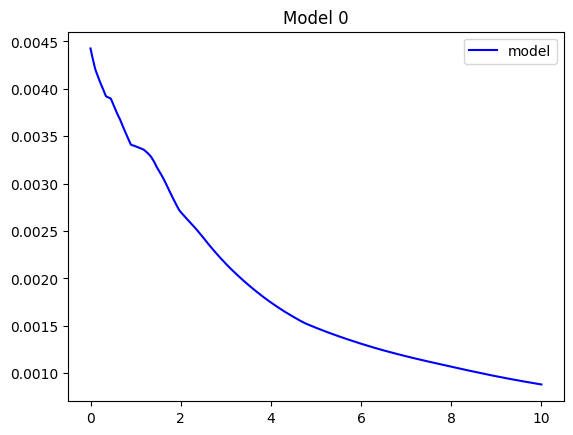

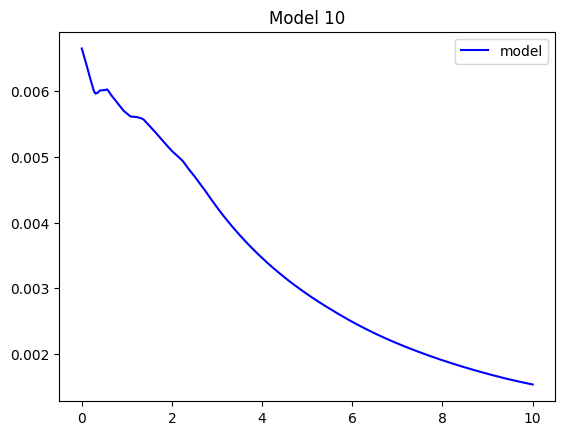

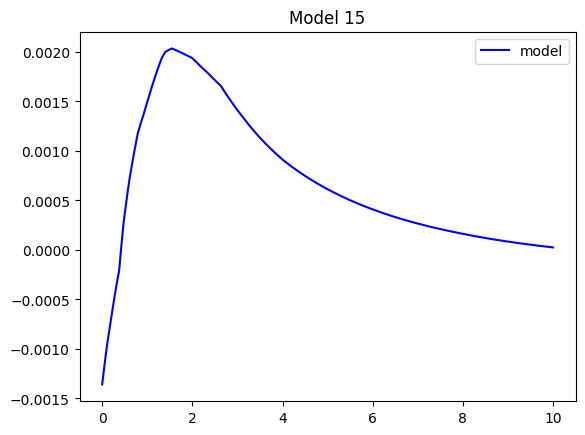

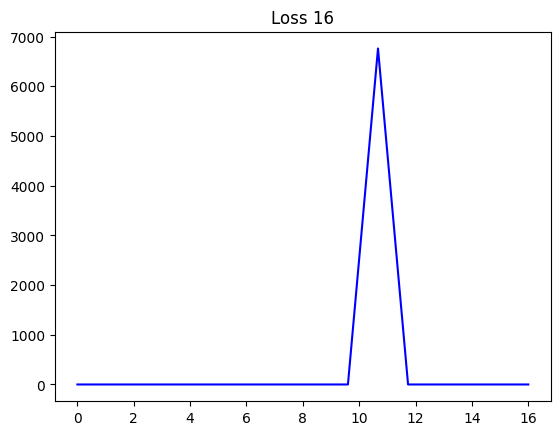

LOSS train 67.60444218557481
-------------- EPOCH 3 --------------
Running kernel S_V
	Loss (0) - 0.0029151550235492277
	Loss (1) - 0.0017001652380573564
	Loss (2) - 0.0014623753879838422
	Loss (3) - 0.0011742214305697162
	Loss (4) - 0.010842224370812798
	Loss (5) - 0.008943026716630257
	Loss (6) - 0.0011943201711998356
	Loss (7) - 0.0010077648707489536
	Loss (8) - 0.005345132892565282
	Loss (9) - 0.002608674161794194
	Loss (10) - 0.0027040390358287103
	Loss (11) - 0.14264815465896755
	Loss (12) - 0.0015744575275934325
	Loss (13) - 0.00653216416603246
	Loss (14) - 0.0010248553878675472
	Loss (15) - 0.0011270112289308372


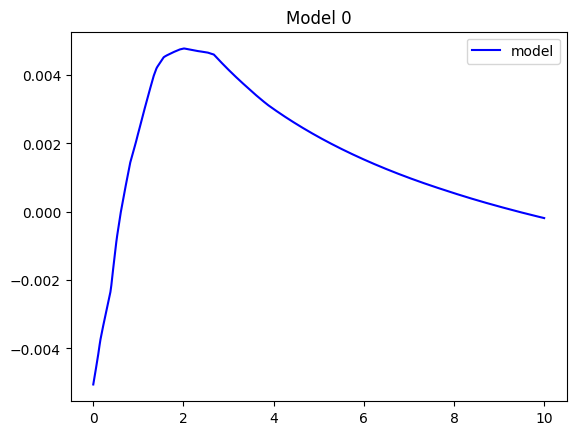

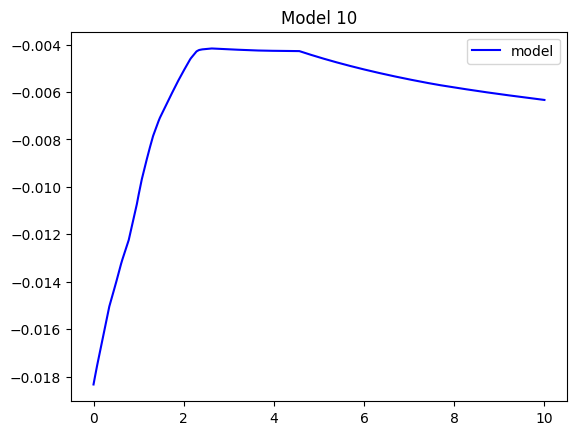

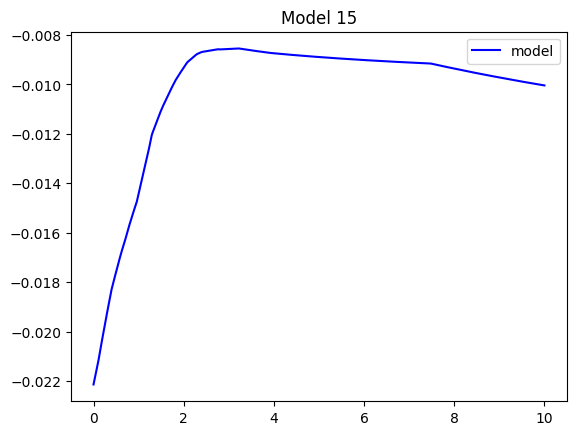

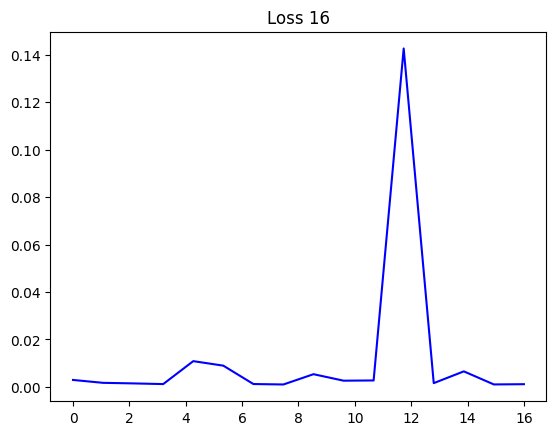

LOSS train 0.00036981944276190946
-------------- EPOCH 4 --------------
Running kernel Sprime_V
	Loss (0) - 8.497098192124153e-09
	Loss (1) - 19259.69069407176
	Loss (2) - 2.229867133178613e-07
	Loss (3) - 2.9513341812123898e-08
	Loss (4) - 6.508159254194085e-06
	Loss (5) - 2.7518412870208586e-09
	Loss (6) - 114.35197129559381
	Loss (7) - 2.48704960325652e-08
	Loss (8) - 1.6170485150270782e-09
	Loss (9) - 2.511127476311817e-10
	Loss (10) - 1.9344577261872143e-05
	Loss (11) - 1.5553265890053616e-09
	Loss (12) - 2.337082587886409e-06
	Loss (13) - 8.661399521355301e-08
	Loss (14) - 1.4141923194688087e-07
	Loss (15) - 2.7250121803748233e-09


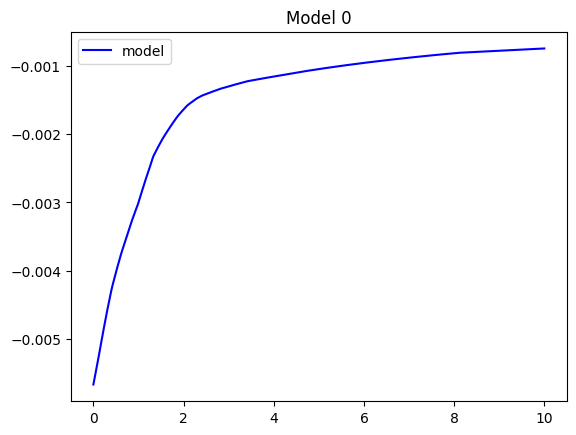

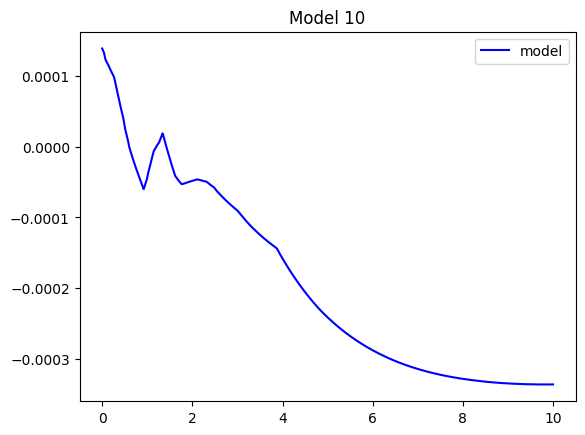

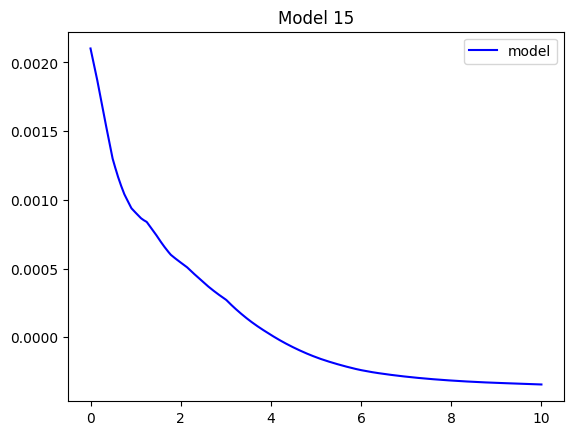

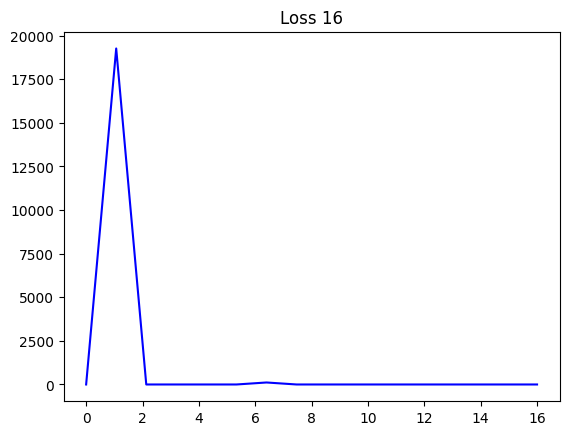

LOSS train 193.74042691502075
-------------- EPOCH 5 --------------
Running kernel S_S
	Loss (0) - 0.0004306087894265898
	Loss (1) - 0.005008512043928337
	Loss (2) - 0.0863197335777557
	Loss (3) - 0.0012140446905852045
	Loss (4) - 0.005508369989743591
	Loss (5) - 0.0022825207878073347
	Loss (6) - 0.002430424720791515
	Loss (7) - 0.0007601258125847555
	Loss (8) - 0.0003875649292291805
	Loss (9) - 0.0007879427785214654
	Loss (10) - 0.0009262295227120445
	Loss (11) - 0.0005511283230574587
	Loss (12) - 0.007047630630307691
	Loss (13) - 8.48206675189327e-05
	Loss (14) - 0.000577326480802177
	Loss (15) - 0.001522285630048492


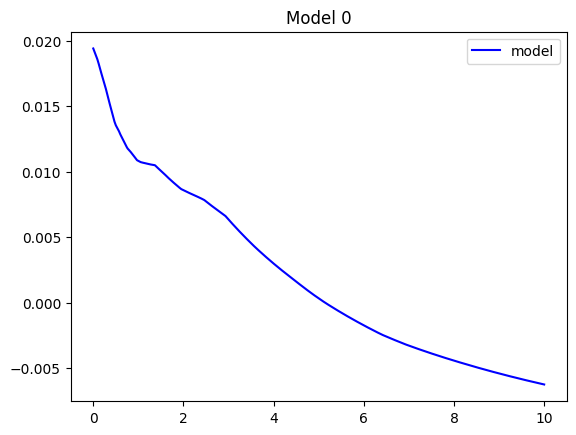

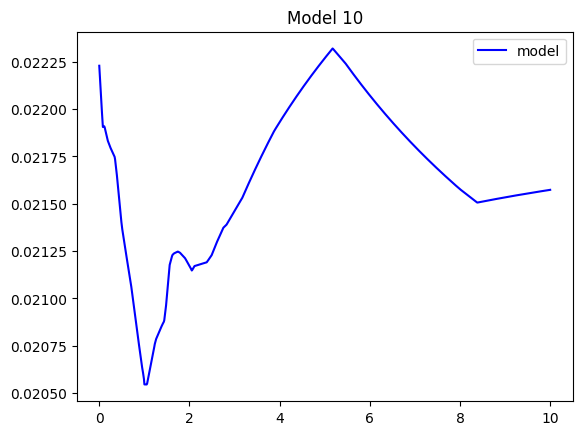

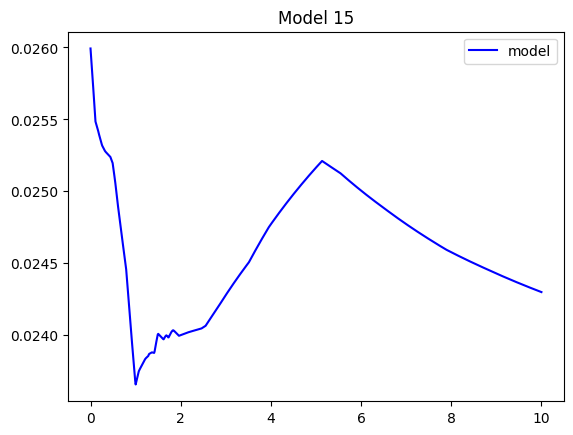

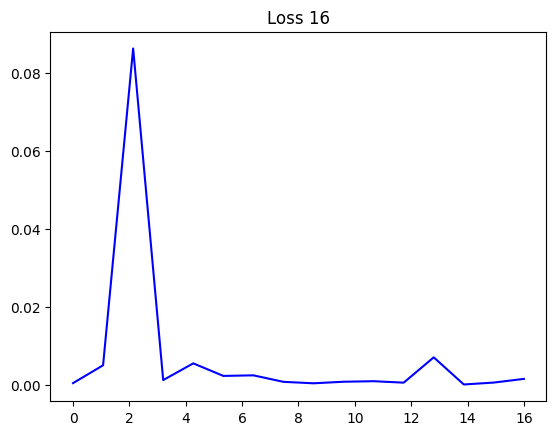

LOSS train 0.0010562546885365912
-------------- EPOCH 6 --------------
Running kernel Sprime_S
	Loss (0) - 5.7457649044823755e-05
	Loss (1) - 0.00039744506622918605
	Loss (2) - 0.0010734853868340983
	Loss (3) - 1.7903329560422254e-05
	Loss (4) - 7.10796019959008e-05
	Loss (5) - 1.4357085718343885e-05
	Loss (6) - 6.482644915730276e-05
	Loss (7) - 1.0882849016964443e-05
	Loss (8) - 0.0009734575660244088
	Loss (9) - 7.289418984299678e-06
	Loss (10) - 1.6623720136236365e-05
	Loss (11) - 7.3551595508073074e-06
	Loss (12) - 6793.683461461707
	Loss (13) - 4.389282586846551e-05
	Loss (14) - 2.8792157192112264e-05
	Loss (15) - 3.187595724622698e-05


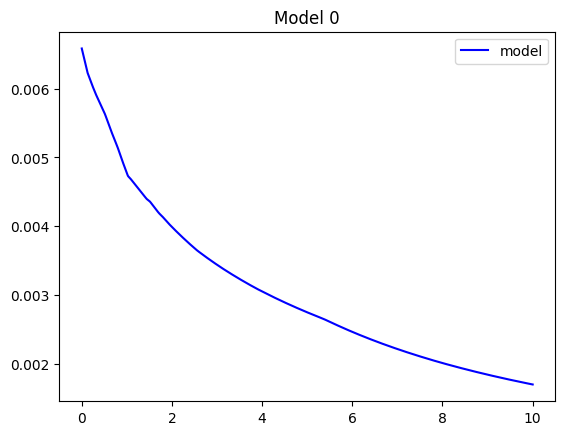

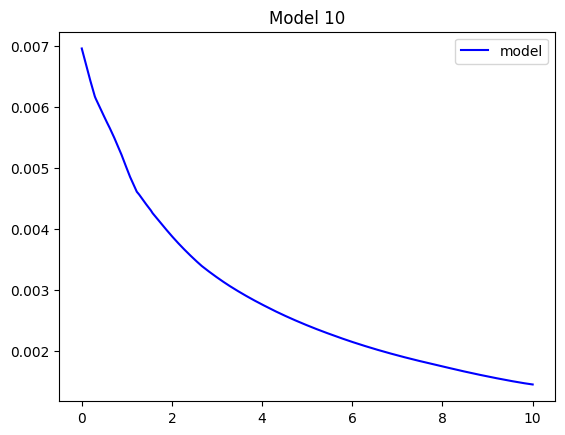

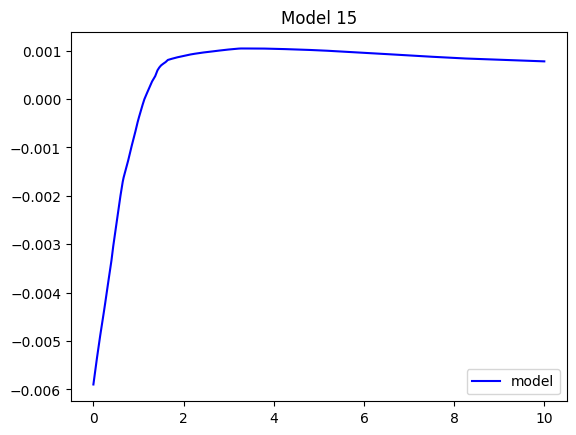

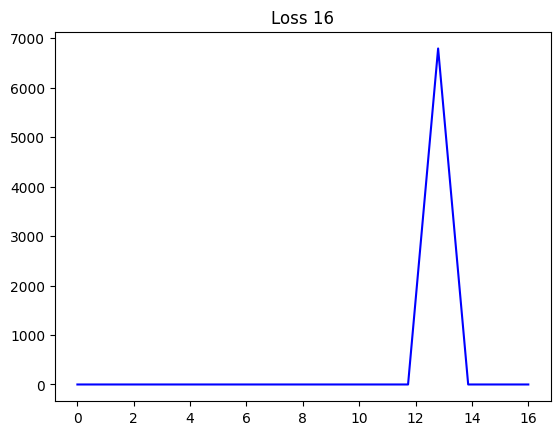

LOSS train 2.6473504736571636e-05
-------------- EPOCH 7 --------------
Running kernel S_V
	Loss (0) - 0.001463085809321959
	Loss (1) - 0.33216210579380534
	Loss (2) - 0.002471028767512496
	Loss (3) - 0.0021574428665076897
	Loss (4) - 0.002161552734906808
	Loss (5) - 0.037791986758033164
	Loss (6) - 0.0027236082889610562
	Loss (7) - 0.005113332741241448
	Loss (8) - 0.0038900928298074367
	Loss (9) - 0.004258296281261927
	Loss (10) - 0.0013129604877866717
	Loss (11) - 0.0019152056842002654
	Loss (12) - 0.0013489868500694317
	Loss (13) - 0.08501173110878475
	Loss (14) - 0.007644457366903903
	Loss (15) - 0.026876933628054774


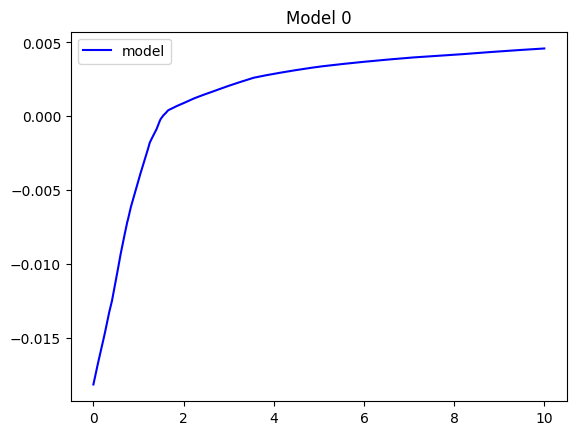

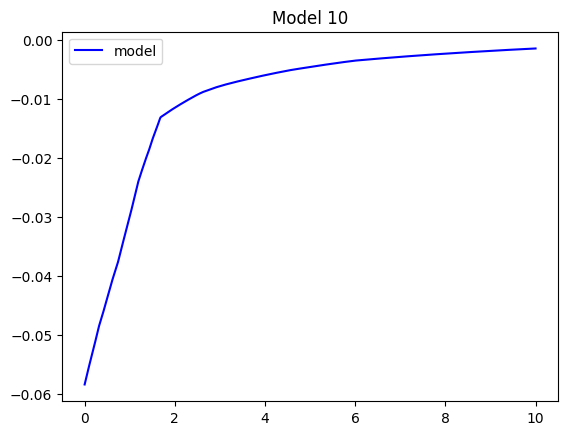

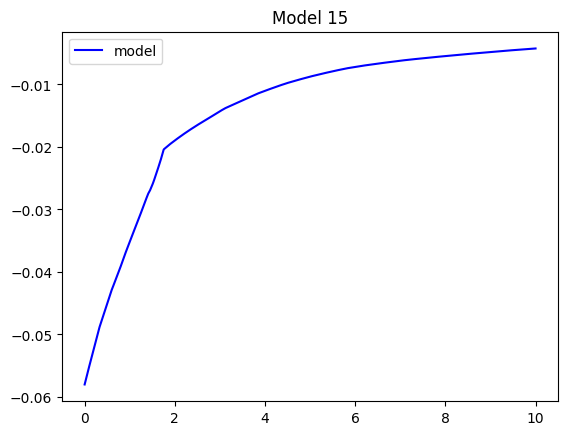

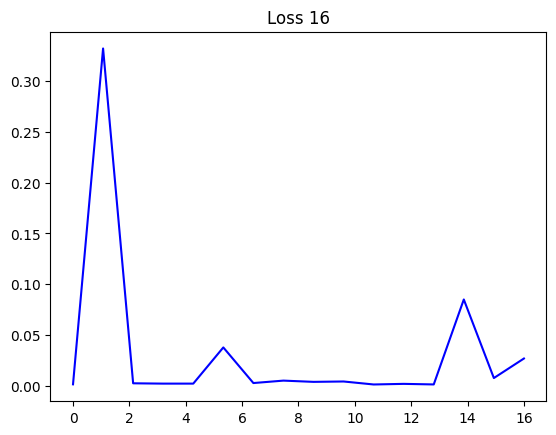

LOSS train 0.003940424075498241
-------------- EPOCH 8 --------------
Running kernel Sprime_V
	Loss (0) - 1.9739954984277364e-06
	Loss (1) - 2.042473501709294e-05
	Loss (2) - 2.38091778232741e-06
	Loss (3) - 9.160379049673579e-08
	Loss (4) - 2.9331365776074822e-06
	Loss (5) - 2.5331713960769203e-07
	Loss (6) - 1.7454940033730838e-07
	Loss (7) - 33742.369447694684
	Loss (8) - 5.305788234298617e-08
	Loss (9) - 1.0692091359510396e-06
	Loss (10) - 8.65591879617789e-05
	Loss (11) - 3.9298372425717695e-05
	Loss (12) - 0.005080946399489043
	Loss (13) - 5.4411601976541e-07
	Loss (14) - 1.8988362625210888e-08
	Loss (15) - 973.2794661929564


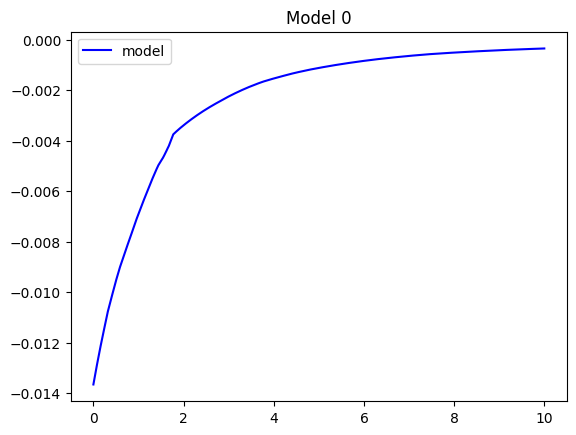

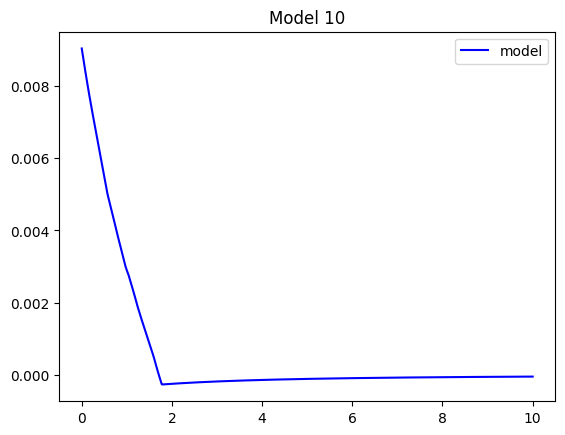

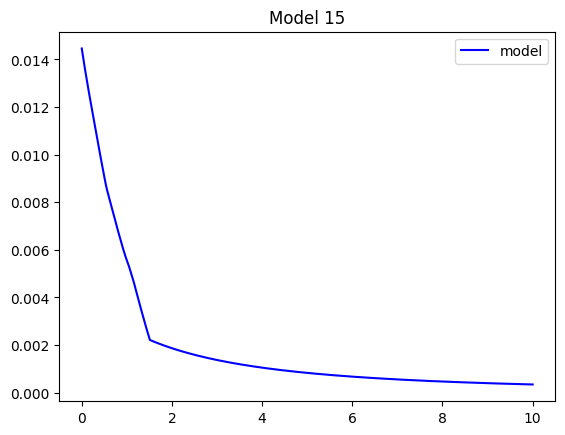

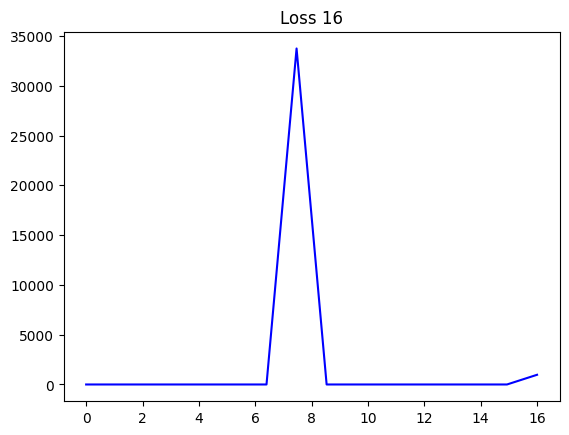

LOSS train 337.423695616344
-------------- EPOCH 9 --------------
Running kernel S_S
	Loss (0) - 0.052910296122368396
	Loss (1) - 0.07935706480488026
	Loss (2) - 0.05954109472857358
	Loss (3) - 0.06215844383759398
	Loss (4) - 0.08727955795480494
	Loss (5) - 0.015669493278439663
	Loss (6) - 0.01203968503332356
	Loss (7) - 0.005926925348316293
	Loss (8) - 0.24290817654790517
	Loss (9) - 0.0032952572535642124
	Loss (10) - 0.004016147577670919
	Loss (11) - 0.0027969357332766768
	Loss (12) - 0.042169287184453466
	Loss (13) - 0.006406208173917771
	Loss (14) - 0.0044070761942098784
	Loss (15) - 0.0020335807176460976


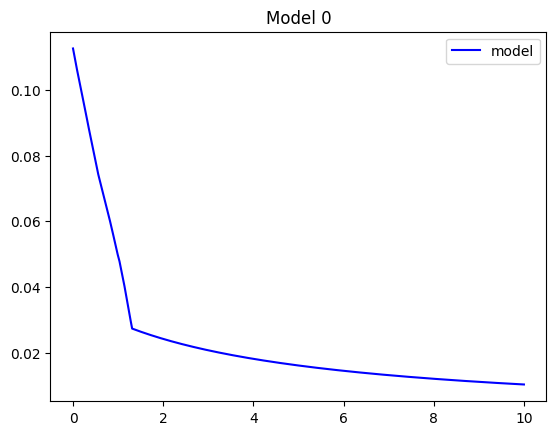

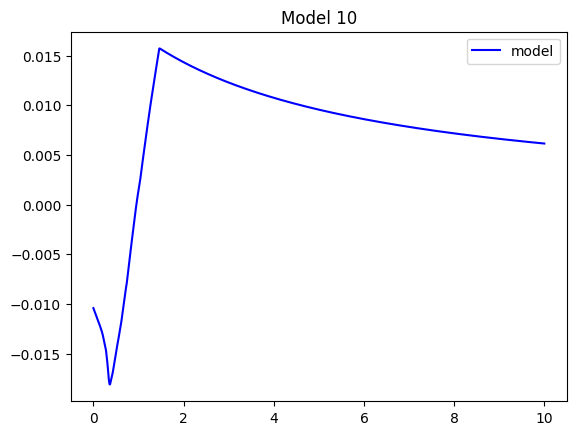

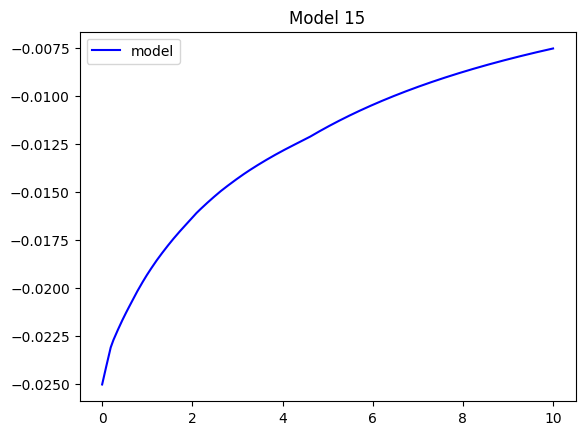

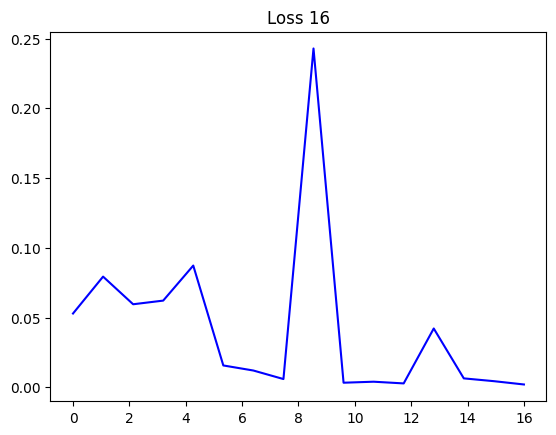

LOSS train 0.005721918463650725
-------------- EPOCH 10 --------------
Running kernel Sprime_S
	Loss (0) - 0.003395560639374451
	Loss (1) - 6.346952792752361e-06
	Loss (2) - 3634.143019464817
	Loss (3) - 1.7024615282740574e-05
	Loss (4) - 0.0005275630614146437
	Loss (5) - 2.643729726033131e-05
	Loss (6) - 6.096336782008886e-06
	Loss (7) - 1.1183196833020907e-05
	Loss (8) - 0.00019436004613735476
	Loss (9) - 0.0001228705690546272
	Loss (10) - 1.1032170215089076e-05
	Loss (11) - 1.1608846480765976e-05
	Loss (12) - 8.583402937769653e-06
	Loss (13) - 0.0006858391937725245
	Loss (14) - 7.732562011069158e-05
	Loss (15) - 7.727466809741894e-06


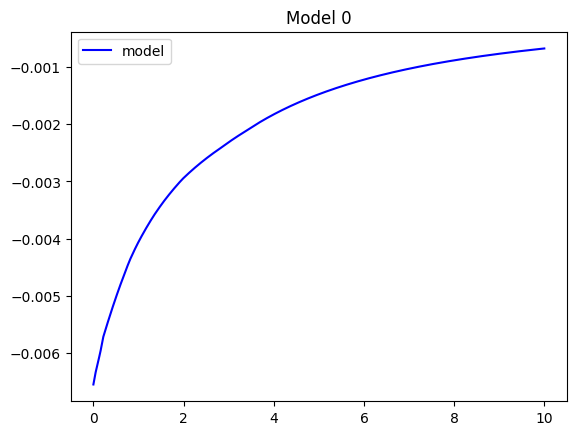

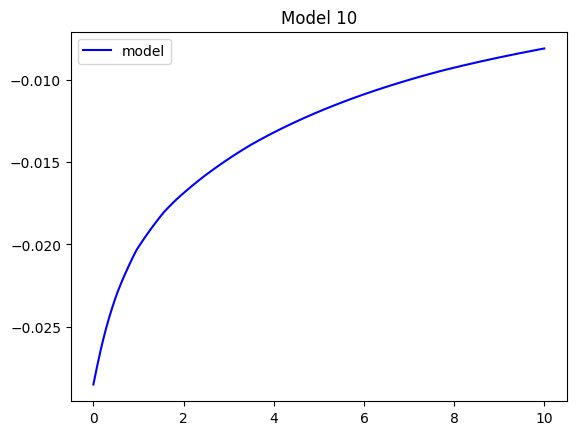

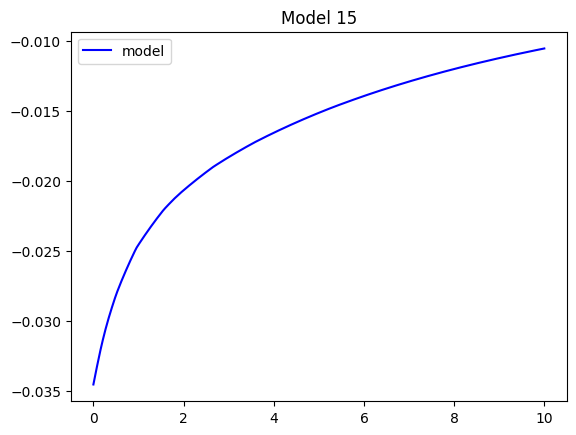

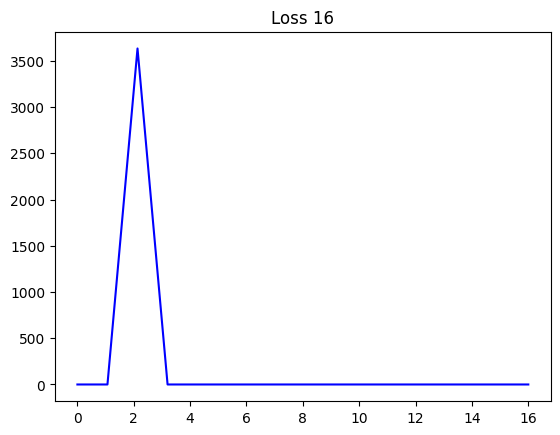

LOSS train 36.341439423790625
-------------- EPOCH 11 --------------
Running kernel S_V
	Loss (0) - 0.009388646257785958
	Loss (1) - 0.008521303656385783
	Loss (2) - 0.0036374388295414115
	Loss (3) - 0.0019182012576423326
	Loss (4) - 0.0015685348070166765
	Loss (5) - 0.0011329180671840616
	Loss (6) - 0.0014291942357421955
	Loss (7) - 0.007508459904170336
	Loss (8) - 0.000995964229886306
	Loss (9) - 0.0033982264233867205
	Loss (10) - 0.006400566691882108
	Loss (11) - 0.0024971890756638002
	Loss (12) - 0.0029962907166108414
	Loss (13) - 0.002115270082890541
	Loss (14) - 0.0018881921263267255
	Loss (15) - 0.0012137864452022923


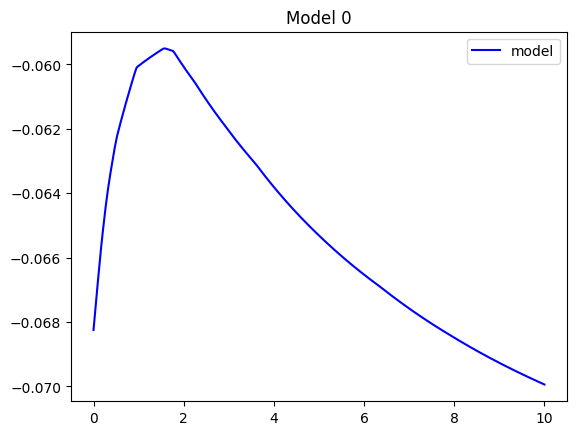

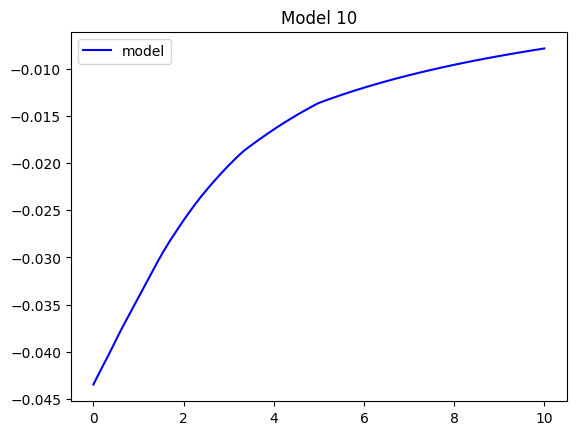

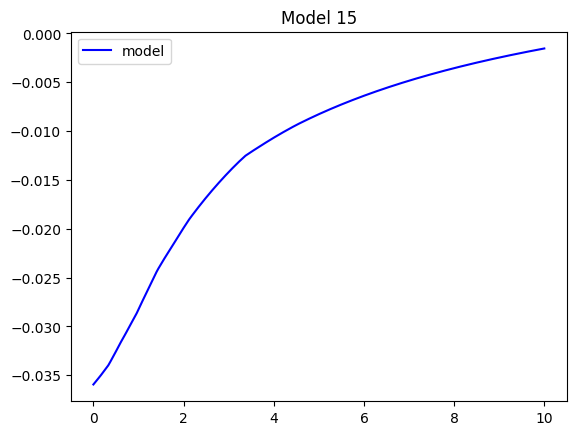

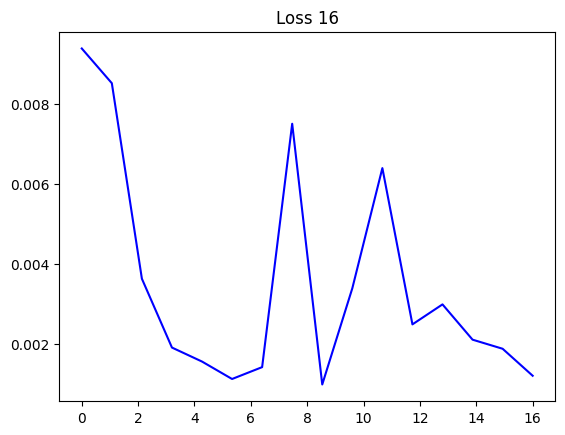

LOSS train 0.0003651080810283793
-------------- EPOCH 12 --------------
Running kernel Sprime_V
	Loss (0) - 7.855630616129022e-09
	Loss (1) - 2.1931024232488274e-09
	Loss (2) - 8.820414968359909e-07
	Loss (3) - 1.6214966476829937e-08
	Loss (4) - 2.487237363932342e-08
	Loss (5) - 0.0019141342509652022
	Loss (6) - 0.00013143178891692508
	Loss (7) - 9.741754370975819e-07
	Loss (8) - 9235.553785204098
	Loss (9) - 3.2507326969772927e-06
	Loss (10) - 1.238773830649185e-08
	Loss (11) - 1.825992417104512e-08
	Loss (12) - 6.4765802126380985e-06
	Loss (13) - 1232.489011169994
	Loss (14) - 0.00020556185761908484
	Loss (15) - 1.2363025168649642e-08


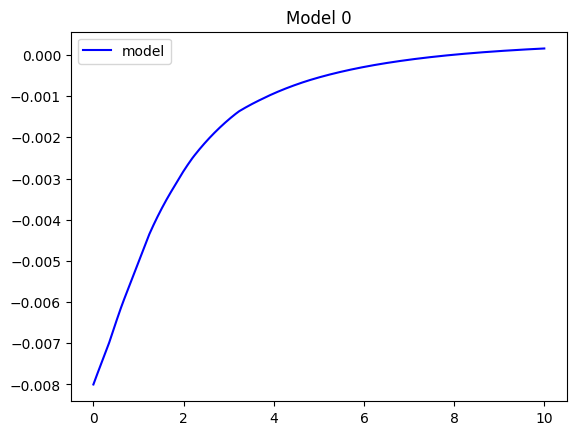

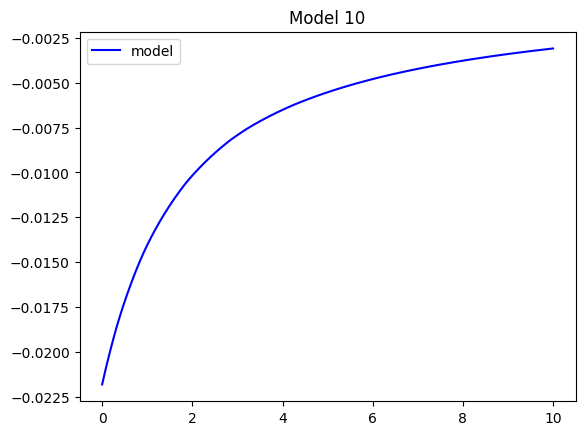

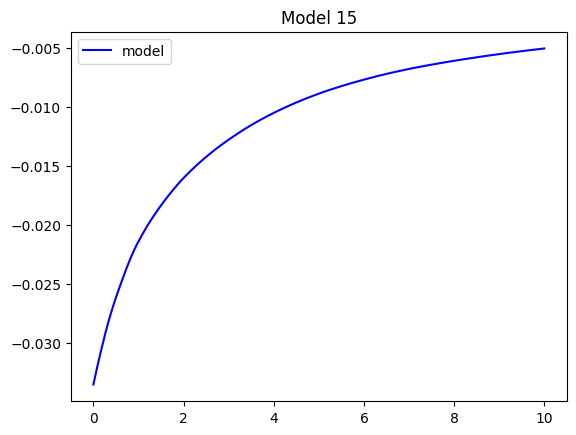

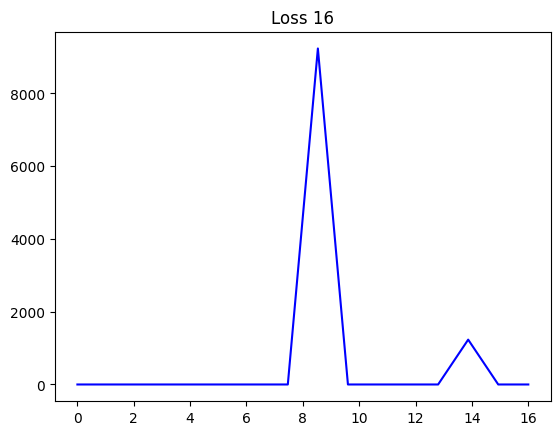

LOSS train 92.35555835932755
-------------- EPOCH 13 --------------
Running kernel S_S
	Loss (0) - 1.8149374238172835
	Loss (1) - 0.15024029738589395
	Loss (2) - 0.10876484180479334
	Loss (3) - 0.057685422355111454
	Loss (4) - 0.1247098956201127
	Loss (5) - 0.09158196050634532
	Loss (6) - 0.09506210785784769
	Loss (7) - 0.3575372998558575
	Loss (8) - 0.21822242639281506
	Loss (9) - 0.1402326036022476
	Loss (10) - 0.08240696888356433
	Loss (11) - 0.07068492298083659
	Loss (12) - 0.16883609676663627
	Loss (13) - 0.10985738076017132
	Loss (14) - 0.1705795964922689
	Loss (15) - 0.15367979275205068


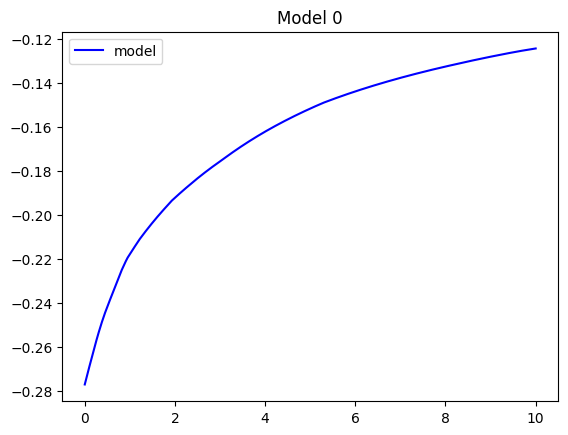

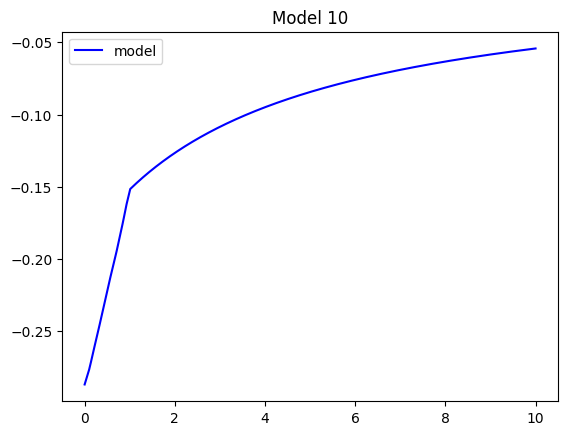

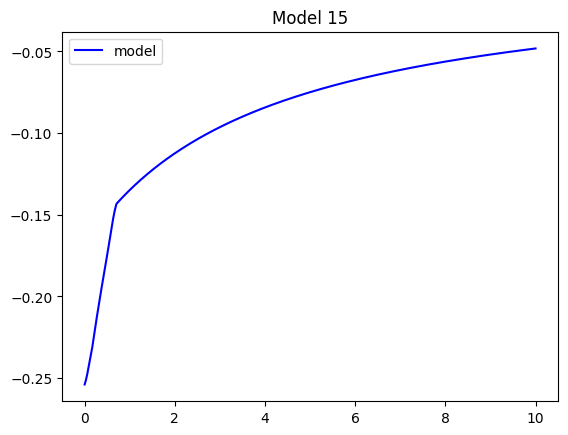

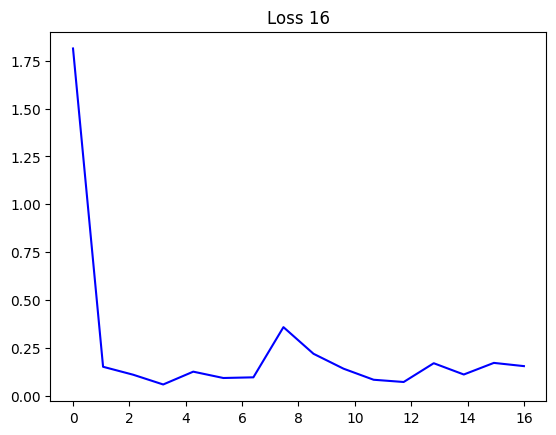

LOSS train 0.014264438242645889
-------------- EPOCH 14 --------------
Running kernel Sprime_S
	Loss (0) - 5.168771313817468e-06
	Loss (1) - 5.5470859552355546e-06
	Loss (2) - 0.023853840764248544
	Loss (3) - 155735.4694787963
	Loss (4) - 4.996606730240511e-06
	Loss (5) - 4.665704095186982e-06
	Loss (6) - 8.59625736918675e-05
	Loss (7) - 2.0039469563695255e-05
	Loss (8) - 0.00011833158295700986
	Loss (9) - 4.68792308247031e-05
	Loss (10) - 3.967925889579448e-05
	Loss (11) - 8.075771029373655e-05
	Loss (12) - 3.643776382738105e-05
	Loss (13) - 0.00015585163353096305
	Loss (14) - 1.80299793041267e-05
	Loss (15) - 1.7521503718370265e-05


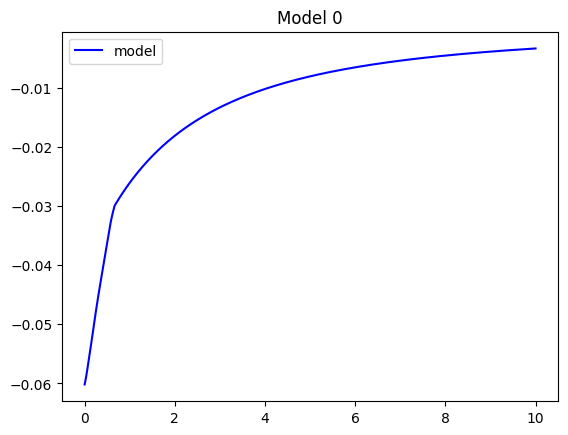

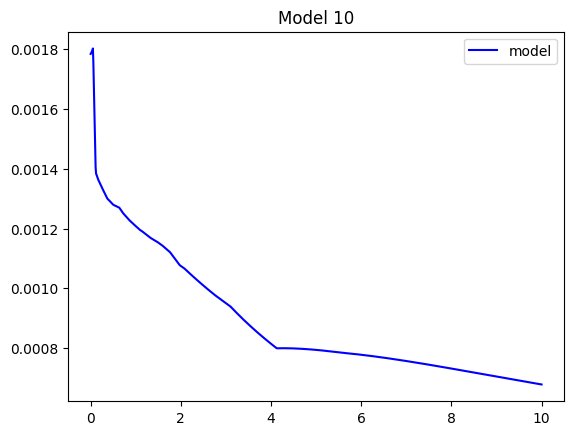

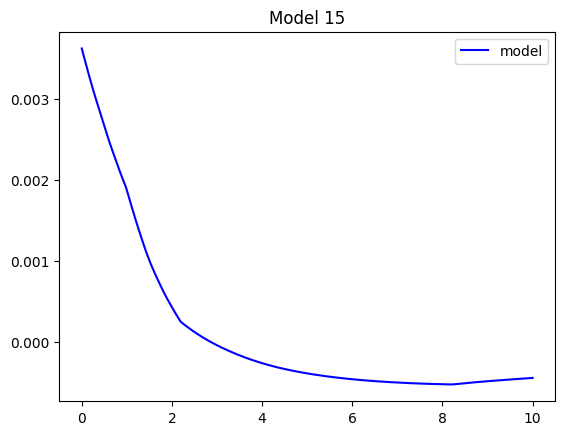

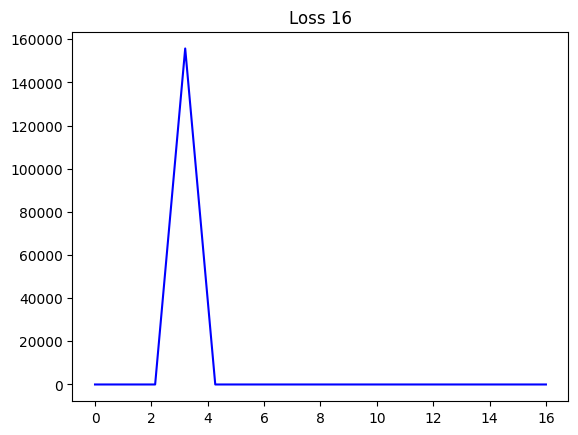

LOSS train 1557.3549365873855
-------------- EPOCH 15 --------------
Running kernel S_V
	Loss (0) - 0.0015668866921418362
	Loss (1) - 0.003308601096478168
	Loss (2) - 0.001048631198155852
	Loss (3) - 0.00499024659279395
	Loss (4) - 0.0016386643806073692
	Loss (5) - 0.0013612301928205123
	Loss (6) - 0.0012009691625104743
	Loss (7) - 0.0014079628446729158
	Loss (8) - 0.002069722481037004
	Loss (9) - 0.0018286587244036655
	Loss (10) - 0.08135997198319656
	Loss (11) - 0.0013412050016781605
	Loss (12) - 0.0014656638410822996
	Loss (13) - 0.001183092012563902
	Loss (14) - 0.0017623765219367039
	Loss (15) - 0.0010226765147730989


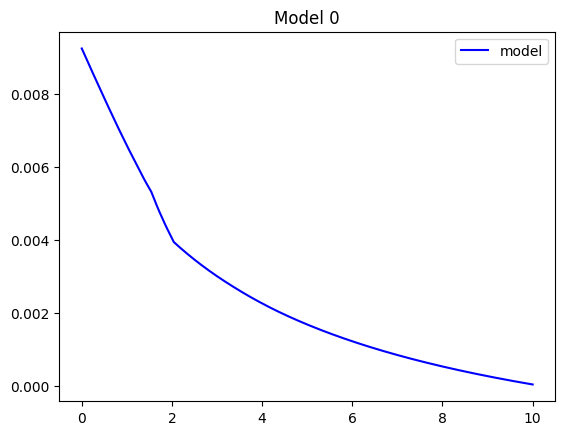

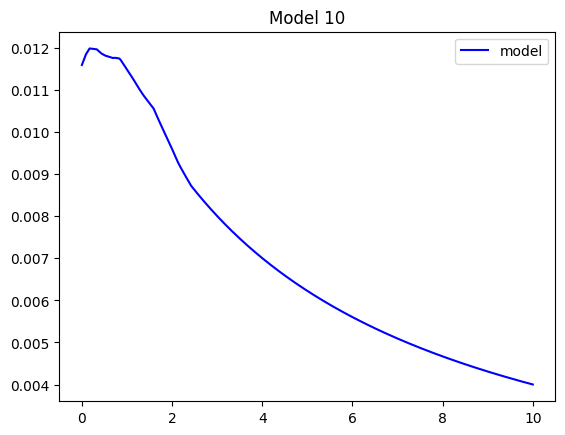

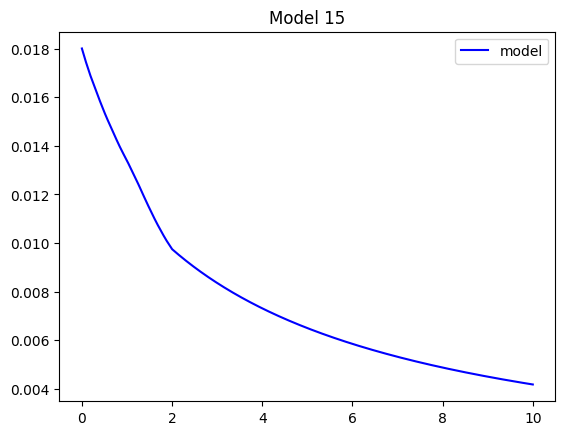

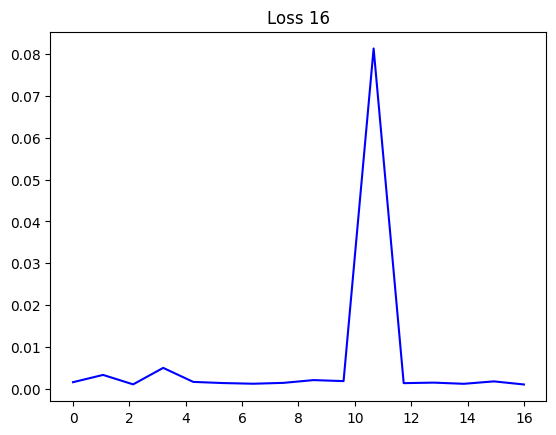

LOSS train 0.0010021465865667645
-------------- EPOCH 16 --------------
Running kernel Sprime_V
	Loss (0) - 3.014367482112195e-05
	Loss (1) - 2.1133879164728425e-07
	Loss (2) - 1.9031068023598026e-08
	Loss (3) - 219.97624592949248
	Loss (4) - 2.8191542748687896e-09
	Loss (5) - 11308.074220303151
	Loss (6) - 9.370104849753508e-07
	Loss (7) - 4.991637689136236e-10
	Loss (8) - 4.555238438972767e-08
	Loss (9) - 1.838971169645761e-09
	Loss (10) - 3.451083606958286e-05
	Loss (11) - 1.6741585906452727e-07
	Loss (12) - 2.6477798520489845e-07
	Loss (13) - 1.418687652057302e-07
	Loss (14) - 1.7467455656726352e-08
	Loss (15) - 1.1978258500839616e-05


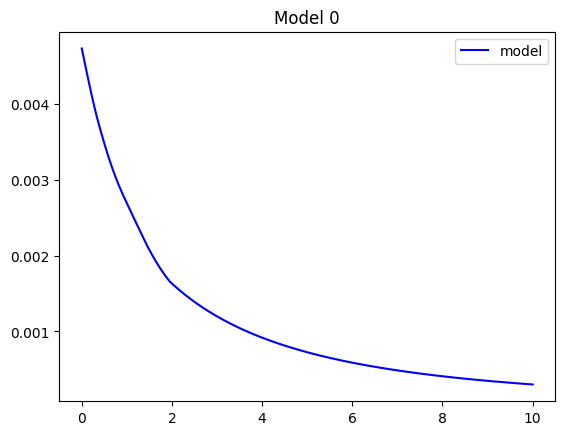

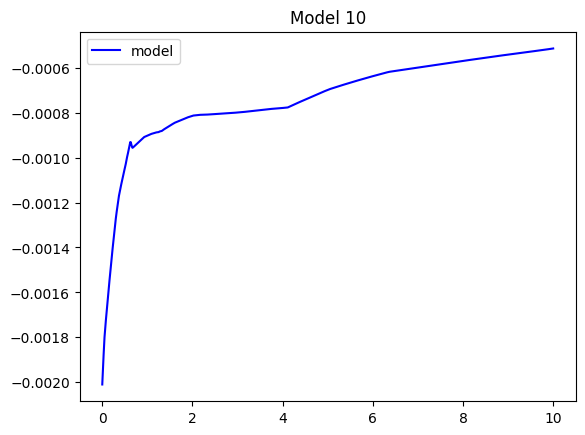

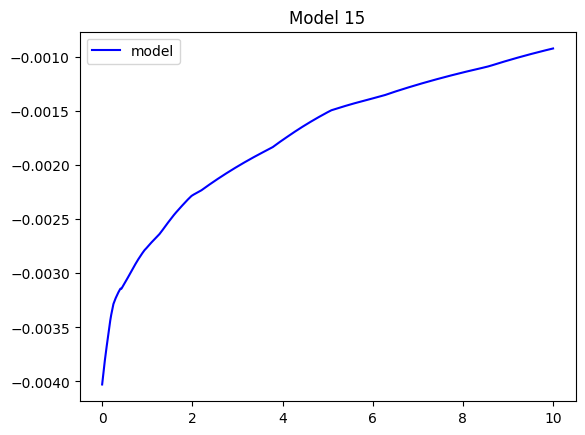

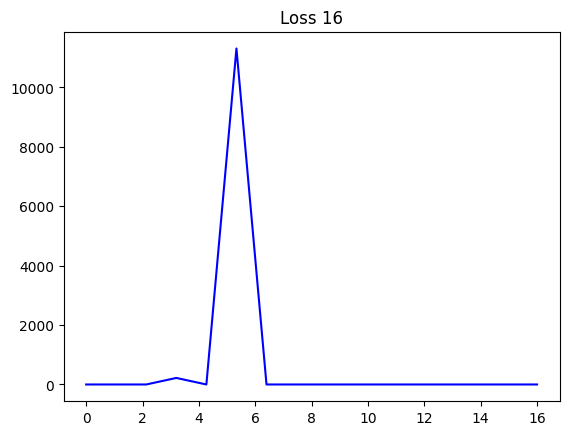

LOSS train 115.2805050196157
-------------- EPOCH 17 --------------
Running kernel S_S
	Loss (0) - 0.014029900060605664
	Loss (1) - 0.010290531268521277
	Loss (2) - 0.013582475711031902
	Loss (3) - 0.006816937247998765
	Loss (4) - 0.06041118343158072
	Loss (5) - 0.0005887791081698211
	Loss (6) - 0.017877919974026026
	Loss (7) - 0.0025950079636136406
	Loss (8) - 0.002546746284445017
	Loss (9) - 0.004767551686744785
	Loss (10) - 0.0011446133676534496
	Loss (11) - 0.0014956287060882041
	Loss (12) - 0.0011420708770933203
	Loss (13) - 0.005205089302134378
	Loss (14) - 0.002142032666026613
	Loss (15) - 0.006030256918456945


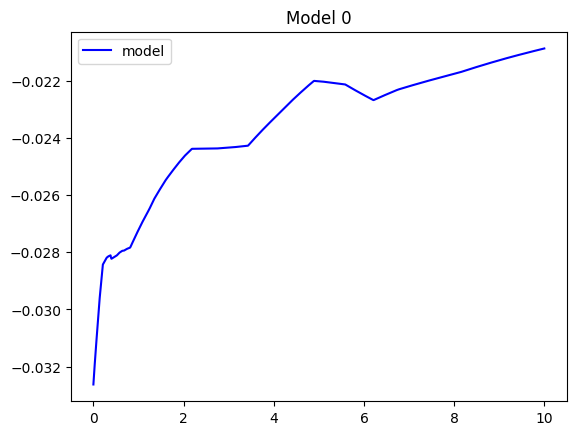

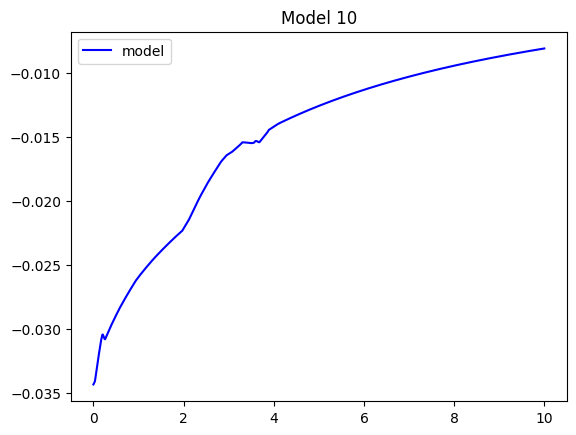

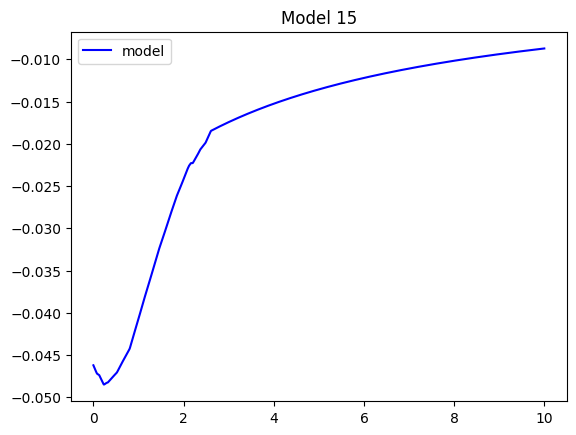

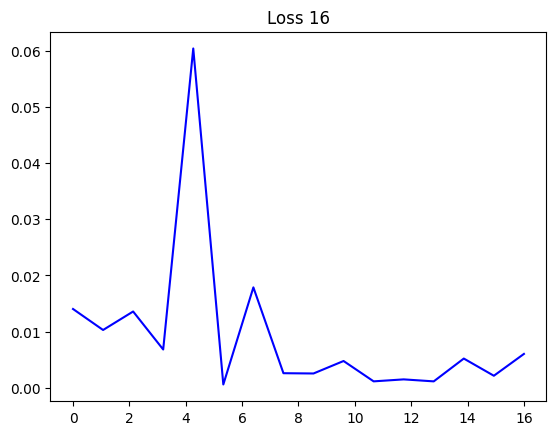

LOSS train 0.001206217460437854
-------------- EPOCH 18 --------------
Running kernel Sprime_S
	Loss (0) - 1.8243517086217782e-05
	Loss (1) - 6.048363581141307e-06
	Loss (2) - 2.544901656147931e-06
	Loss (3) - 0.005331850253868179
	Loss (4) - 0.00010255810539792901
	Loss (5) - 8.378119623462904e-05
	Loss (6) - 7.353233476698173e-06
	Loss (7) - 9.806483497815997e-06
	Loss (8) - 1.5078153920562524e-05
	Loss (9) - 0.001073837859212146
	Loss (10) - 0.00046623851209652415
	Loss (11) - 1.1435734894373105e-05
	Loss (12) - 1.0859034552536907e-05
	Loss (13) - 6.081487311429837e-06
	Loss (14) - 94546.73798063328
	Loss (15) - 2.7973418581759194e-05


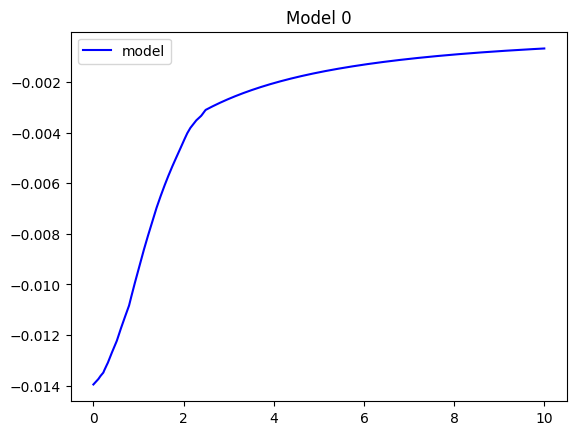

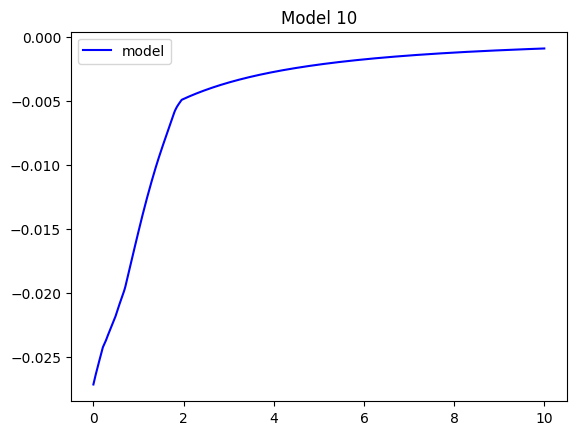

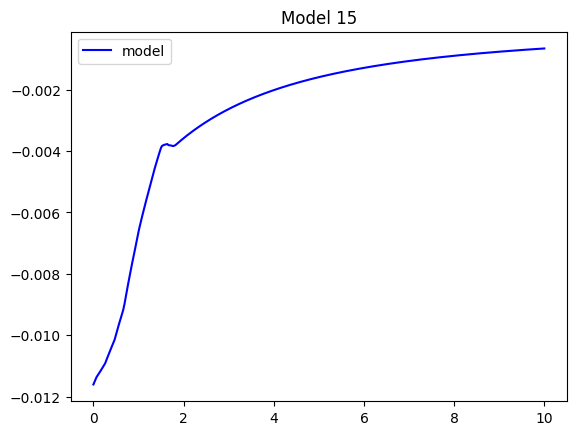

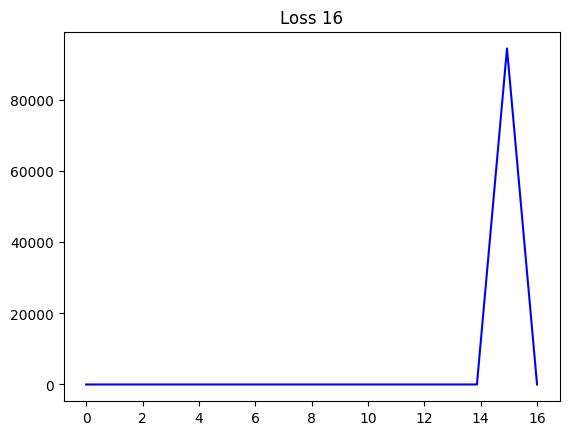

LOSS train 7.099097062941772e-05
-------------- EPOCH 19 --------------
Running kernel S_V
	Loss (0) - 0.009177688664281309
	Loss (1) - 0.004090486086093341
	Loss (2) - 0.0014651514405050667
	Loss (3) - 0.0010479499803976078
	Loss (4) - 0.001433626668615877
	Loss (5) - 0.0012122938909925412
	Loss (6) - 0.0010738936558580886
	Loss (7) - 0.0013064008855221269
	Loss (8) - 0.0012187246177437958
	Loss (9) - 0.002817737995198223
	Loss (10) - 0.001051535488896455
	Loss (11) - 0.001933911289283346
	Loss (12) - 0.0009064190229144364
	Loss (13) - 0.0016104513027414991
	Loss (14) - 0.18358870458525442
	Loss (15) - 0.0009987987655817171


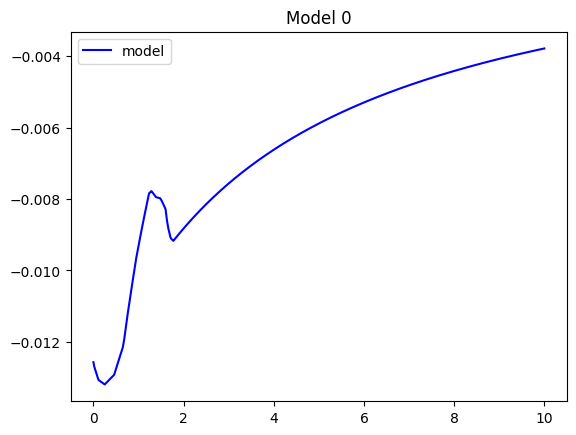

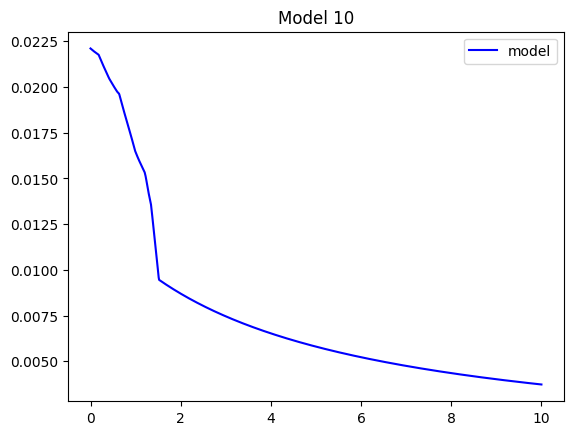

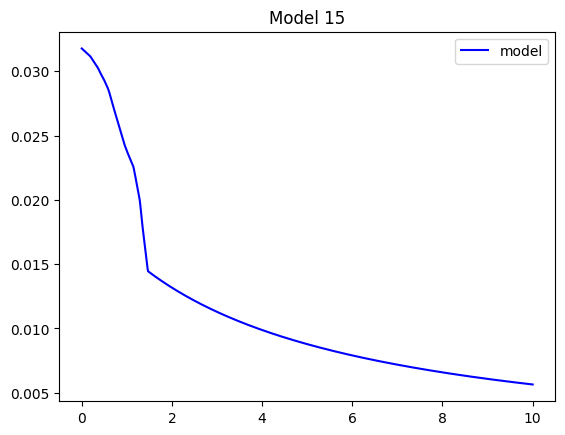

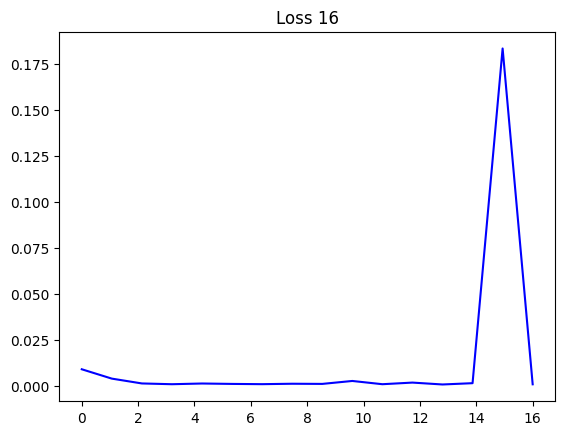

LOSS train 0.00016717800709823124
-------------- EPOCH 20 --------------
Running kernel Sprime_V
	Loss (0) - 3.56708539016965e-06
	Loss (1) - 15726.258430369933
	Loss (2) - 3.5079255000297767e-06
	Loss (3) - 1.0269853310165674e-05
	Loss (4) - 8.274605861881975e-07
	Loss (5) - 5.560415044713984e-10
	Loss (6) - 6.18786705129563e-08
	Loss (7) - 1.0751848124336104e-09
	Loss (8) - 2.1688471827495244e-07
	Loss (9) - 0.0004080473473014247
	Loss (10) - 7.384100509682723e-09
	Loss (11) - 140.71152114874454
	Loss (12) - 7.845727605349136e-09
	Loss (13) - 1.4594207524764478e-07
	Loss (14) - 1.2541998464014575e-09
	Loss (15) - 2.9240150333368317e-09


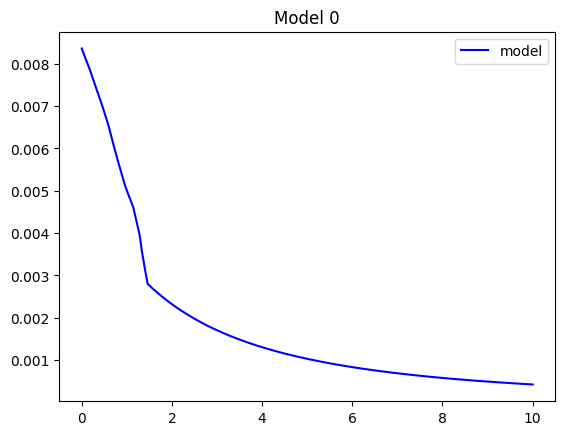

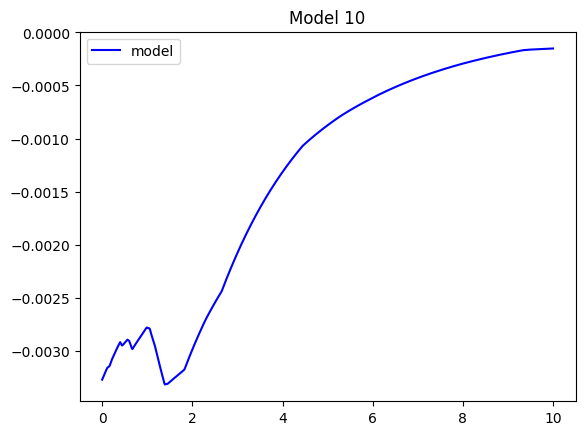

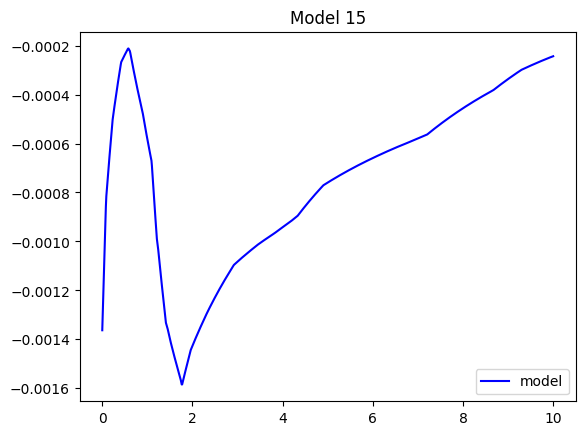

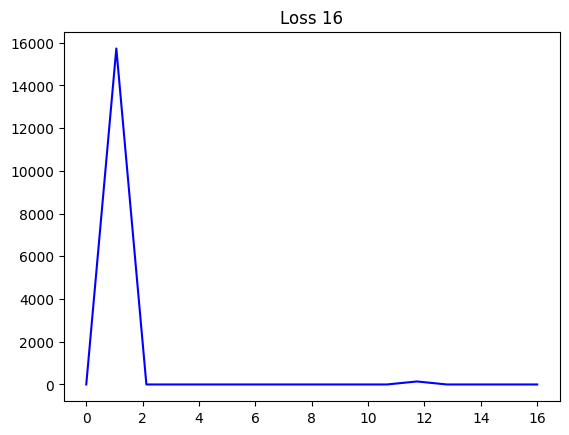

LOSS train 157.26258853310298


ValueError: x and y must have same first dimension, but have shapes (41,) and (20,)

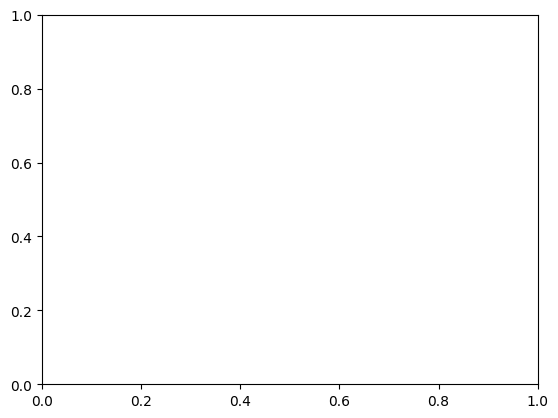

In [5]:

epoch_loss = []

for epoch in range(EPOCHS):
    print('-------------- EPOCH {} --------------'.format(epoch + 1))
    data_idx = epoch % len(data_names)
    data_name = data_names[data_idx]
    print(f"Running kernel {data_name}")
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(
        epoch, 
        optimizer=optimizer, 
        data_loader=data_loaders[data_name], 
        model=model, 
        kernel=kernels[data_name]
    )
    epoch_loss.append(avg_loss)

    model_controller.save(f"src/models/models/simple_model_epoch_{epoch}.pt")

    print(f'LOSS train {avg_loss}')
    # plt.close()

    EPOCHS += 1

plot_loss(EPOCHS, epoch_loss)
plt.show()

model_controller.save()